In [1]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd

st = default_timer()

# First time data load
movies = pd.read_csv("movie.csv")
ratings = pd.read_csv("rating.csv")

# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp     object
dtype: object
Number of movies Null values:  22
Number of ratings Null values:  0
Elapsed time(sec):  104.57


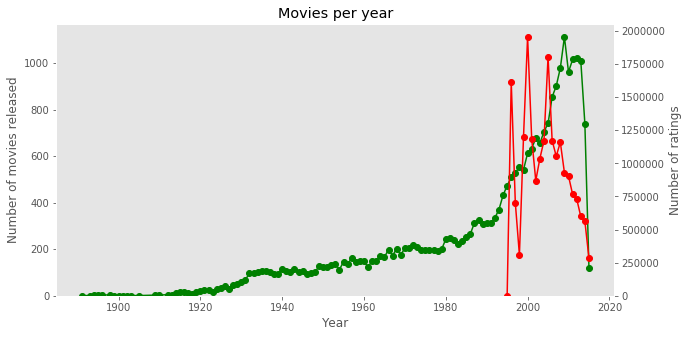

Elapsed time(sec):  2.31


In [3]:
st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<Figure size 720x360 with 0 Axes>

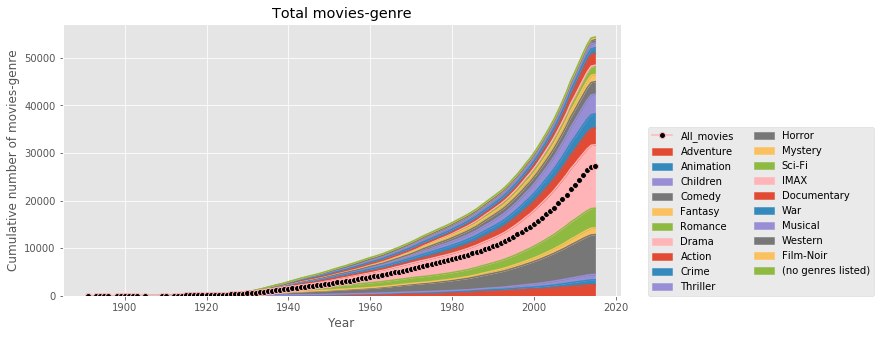

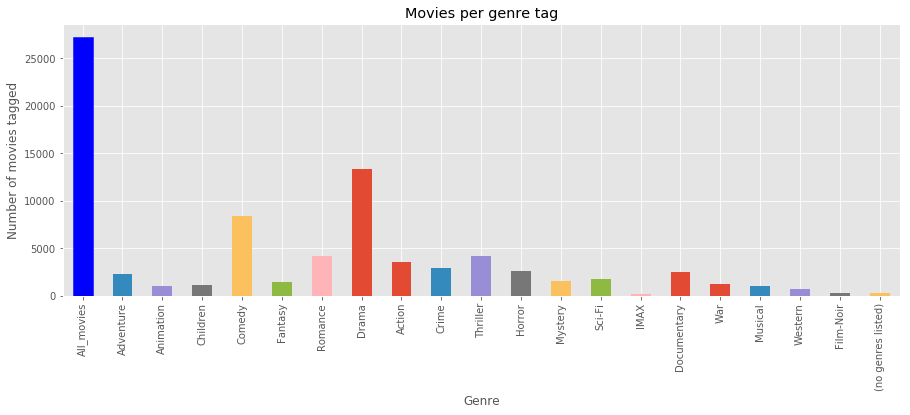

Elapsed time(sec):  1.26


In [4]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

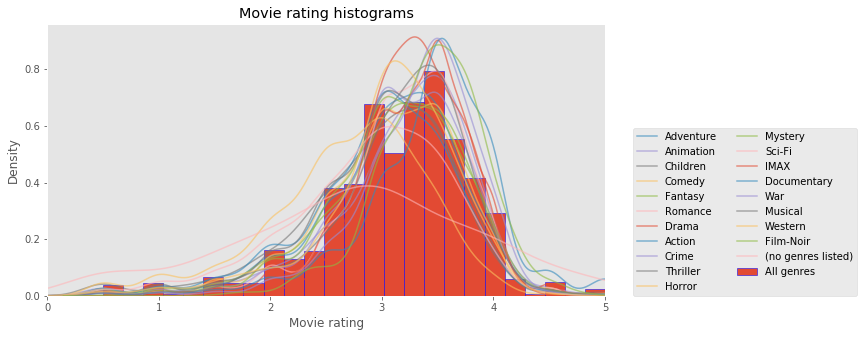

Elapsed time(sec):  70.47


In [10]:
st = default_timer()

dftmp = ratings[['movieId','rating']].groupby('movieId').mean()

# Initialize empty list to capture basic stats by gere
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', normed=True, label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]==True]
    dftmp = ratings[ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

# Housekeeping
%reset_selective -f (^avg$|^dftmp$|^genre$|^std$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

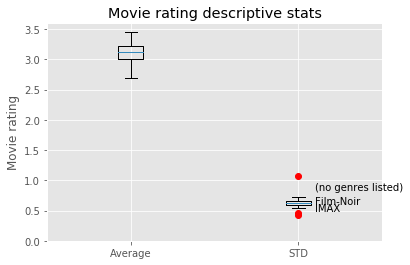

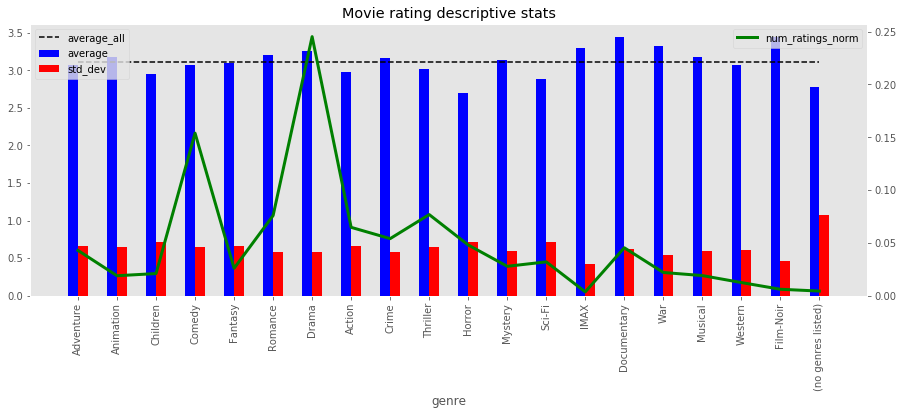

Outliers:  {'(no genres listed)', 'IMAX', 'Film-Noir'}
genre             Adventure  Animation  Children    Comedy   Fantasy  \
average            3.072407   3.177095  2.955608  3.074271  3.093084   
std_dev            0.658817   0.652727  0.711403  0.648962  0.661956   
num_ratings_norm   0.042831   0.018887  0.020947  0.153910  0.025949   
average_all        3.112275   3.112275  3.112275  3.112275  3.112275   

genre              Romance     Drama    Action     Crime  Thriller    Horror  \
average           3.205743  3.262057  2.976834  3.166853  3.016069  2.696796   
std_dev           0.583832  0.581126  0.665900  0.584603  0.643598  0.720493   
num_ratings_norm  0.075897  0.245329  0.064716  0.054031  0.076817  0.048018   
average_all       3.112275  3.112275  3.112275  3.112275  3.112275  3.112275   

genre              Mystery    Sci-Fi      IMAX  Documentary       War  \
average           3.134997  2.889511  3.294670     3.436628  3.321137   
std_dev           0.593284  0.720313 

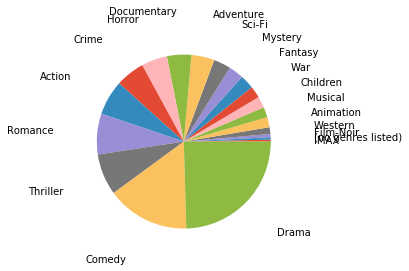

Elapsed time(sec):  2.63


In [11]:
st = default_timer()

# Construct a DataFrame with all the basic stats per genre
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)
# Display a boxplot to show the dispersion of average and standard deviation
bxplot = plt.boxplot(rating_sum.T, labels=['Average', 'STD'], sym="ro")
# Properly label the outliers
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # Trick to prevent overlapping
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

# Bar chart with average rating, standard deviation and normalized number of ratings per genre
# Calculate the normalized number of ratings per genre
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
# Calculate the average rating for all genres
rating_sum['average_all']=rating_sum.average.mean()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

rating_sum[['average', 'std_dev']].plot(kind='bar', color=['b','r'], ax=ax, position=0.5, grid=False)
rating_sum['average_all'].plot(kind='line',style='--', color=['black'], ax=ax, grid=False)
rating_sum['num_ratings_norm'].plot(kind='line', color='g', ax=ax2, grid=False, linewidth=3)

ax.legend(loc=2)
ax2.legend(loc=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Movie rating descriptive stats')
plt.autoscale()
ax2.set_ylim(0,)
plt.show()

print("Outliers: ", outliers)
print(rating_sum.T)

# Quick pie chart to visualize how 3 genres take almost 50% of ratings
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()


# Housekeeping
%reset_selective -f (^avg$|ax|bxplot|^df$|^dftmp$|^i$|^rating_stats$|^rating_sum$|^val$|^value$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

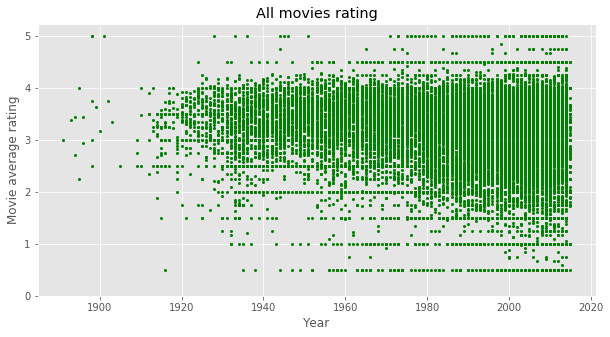

Elapsed time(sec):  1.49


In [12]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

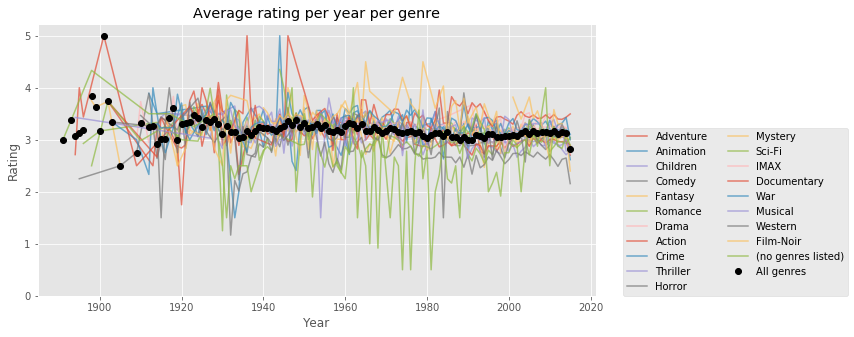

Elapsed time(sec):  56.25


In [13]:
st = default_timer()

plt.figure(figsize=(10,5))
# For each genre
for genre in genres_unique.genre:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year per genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

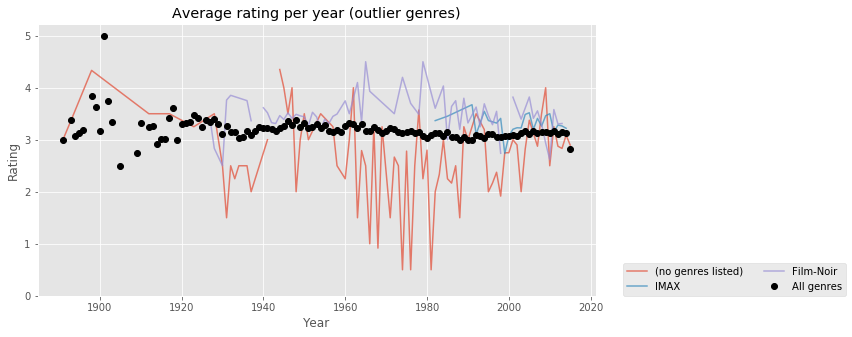

Elapsed time(sec):  11.97


In [14]:
st = default_timer()

plt.figure(figsize=(10,5))
for genre in outliers:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')
    
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year (outlier genres)')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$|^outliers$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

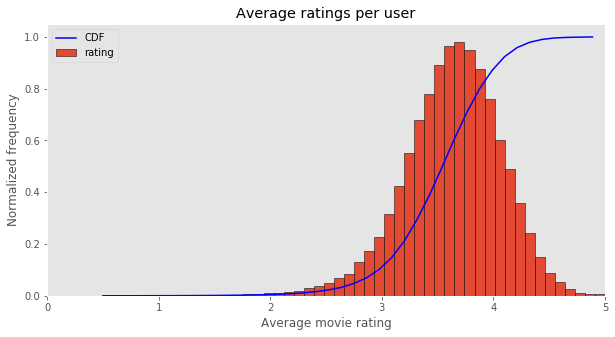

Elapsed time(sec):  3.97


In [15]:
st = default_timer()

dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, normed=True, edgecolor='black', figsize=(10,5))
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, normed=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

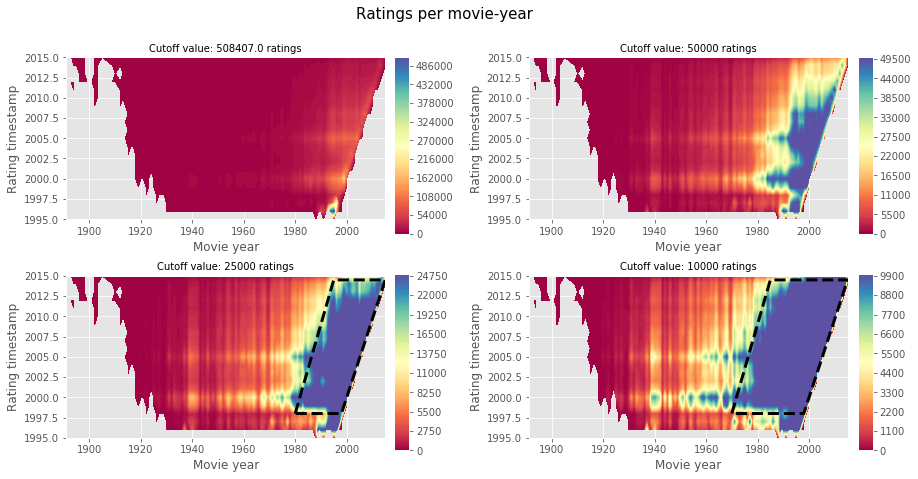

Elapsed time(sec):  9.51


In [27]:
st = default_timer()
# Combine movies year with ratings timestamps
dftmp = movies[['movieId', 'year']].merge(ratings[['movieId', 'timestamp']], on='movieId')
dftmp = dftmp.groupby(['year', 'timestamp']).count().reset_index()
dftmp.columns=['year', 'timestamp', 'count']
dftmp = dftmp.pivot('year', 'timestamp')

# Plot using a contour (color reflects number of ratings for each year-timestamp pair).
# Could also use heatmap or imshow...
X=dftmp.columns.levels[1].values
Y=dftmp.index.values
Z=dftmp.values
Xi,Yi = np.meshgrid(X, Y)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(14,7)
cutoff = [np.nanmax(Z), 50000, 25000, 10000] # Modify the contour plots a different max values.
Zcap = np.copy(Z)
locx = [0.45, 0.91, 0.45, 0.91] # x location for the individual colorbars
locy = [0.53, 0.53, 0.1, 0.1] # y location for the individual colorbar
for i, ax in enumerate(axs.flatten()):
    Zcap[Zcap>cutoff[i]]=cutoff[i]
    cmvals = ax.contourf(Yi, Xi, Zcap, 100, cmap=plt.cm.get_cmap("Spectral"))
    ax.set_xlabel('Movie year')
    ax.set_ylabel('Rating timestamp')
    ax.set_title('Cutoff value: %s ratings' %cutoff[i], fontsize=10)
    cax = fig.add_axes([locx[i], locy[i], 0.015, 0.35])
    fig.colorbar(cmvals, cax=cax, orientation='vertical')
fig.suptitle('Ratings per movie-year', fontsize=15)
plt.subplots_adjust(hspace=0.35,wspace=0.45)

# Highlight key regions in the plots, just roughly...
axs.flatten()[2].plot([1980, 1995, 2015, 1998, 1980], [1998, 2014.5, 2014.5, 1998, 1998], 
                      '--', color='black',linewidth=3)
axs.flatten()[3].plot([1970, 1985, 2015, 1998, 1970], [1998, 2014.5, 2014.5, 1998, 1998], 
                      '--', color='black',linewidth=3)
plt.show()

# Housekeeping
%reset_selective -f (^ax$|^axs$|^cmvals$|^cutoff$|^dftmp$|^i$|loc|X|Y|Z)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

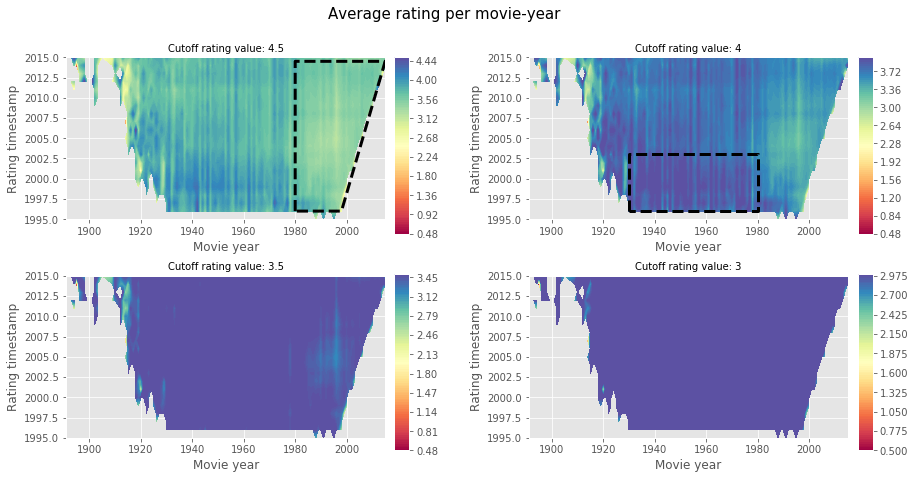

Elapsed time(sec):  11.26


In [28]:
st = default_timer()
# Combine movies year with ratings timestamps
dftmp = movies[['movieId', 'year']].merge(ratings[['movieId', 'timestamp', 'rating']], on='movieId')
dftmp.drop('movieId', axis=1, inplace=True)
dftmp = dftmp.groupby(['year', 'timestamp']).mean().reset_index().pivot('year', 'timestamp')

# Plot using a contour (color reflects number of ratings for each year-timestamp pair).
# Could also use heatmap or imshow...
X=dftmp.columns.levels[1].values
Y=dftmp.index.values
Z=dftmp.values
Xi,Yi = np.meshgrid(X, Y)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(14,7)
cutoff = [4.5, 4, 3.5, 3] # Modify the contour plots a different max values.
Zcap = np.copy(Z)
locx = [0.45, 0.91, 0.45, 0.91] # x location for the individual colorbars
locy = [0.53, 0.53, 0.1, 0.1] # y location for the individual colorbar
for i, ax in enumerate(axs.flatten()):
    Zcap[Zcap>cutoff[i]]=cutoff[i]
    cmvals = ax.contourf(Yi, Xi, Zcap, 100, cmap=plt.cm.get_cmap("Spectral"))
    ax.set_xlabel('Movie year')
    ax.set_ylabel('Rating timestamp')
    ax.set_title('Cutoff rating value: %s' %cutoff[i], fontsize=10)
    cax = fig.add_axes([locx[i], locy[i], 0.015, 0.35])
    fig.colorbar(cmvals, cax=cax, orientation='vertical')
fig.suptitle('Average rating per movie-year', fontsize=15)
plt.subplots_adjust(hspace=0.35,wspace=0.45)

# Highlight key regions in the plots, just roughly...
axs.flatten()[0].plot([1980, 1980, 2015, 1998, 1980], [1996, 2014.5, 2014.5, 1996, 1996], 
                      '--', color='black', linewidth=3)
axs.flatten()[1].plot([1930, 1930, 1980, 1980, 1930], [1996, 2003, 2003, 1996, 1996], 
                      '--', color='black', linewidth=3)
plt.show()

# Housekeeping
%reset_selective -f (^ax$|^axs$|^cax$|^cmvals$|^cutoff$|^dftmp$|^fig$|^i$|loc|X|Y|Z)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

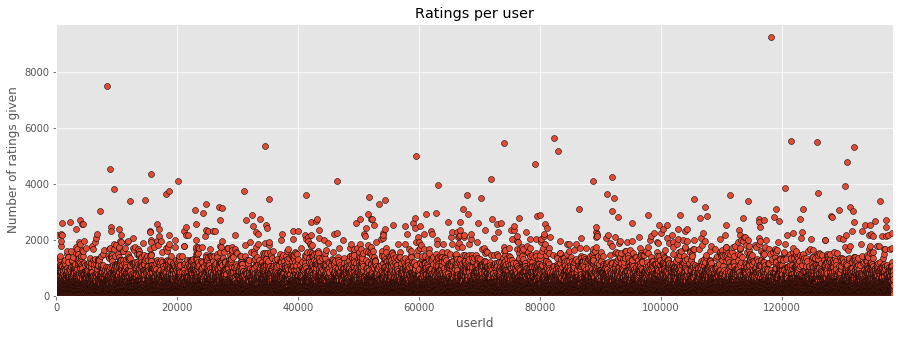

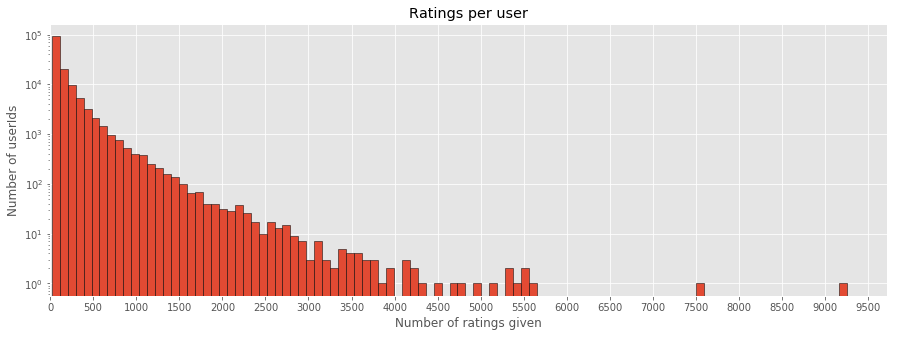

Elapsed time(sec):  6.23


In [29]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of userIds')
plt.xlim(0,)
plt.xticks(np.arange(0,10000,500))
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

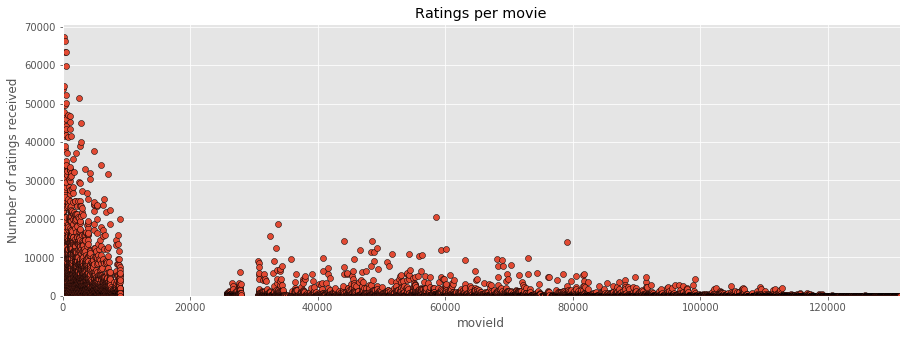

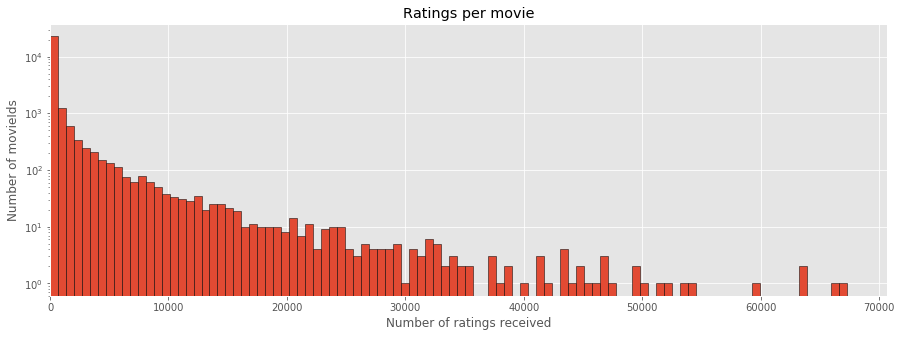

movieId
1                                               Toy Story
32                     Twelve Monkeys (a.k.a. 12 Monkeys)
47                                   Seven (a.k.a. Se7en)
50                                    Usual Suspects, The
110                                            Braveheart
150                                             Apollo 13
260                    Star Wars: Episode IV - A New Hope
296                                          Pulp Fiction
318                             Shawshank Redemption, The
356                                          Forrest Gump
377                                                 Speed
380                                             True Lies
457                                         Fugitive, The
480                                         Jurassic Park
527                                      Schindler's List
588                                               Aladdin
589                            Terminator 2: Judgment Day
590   

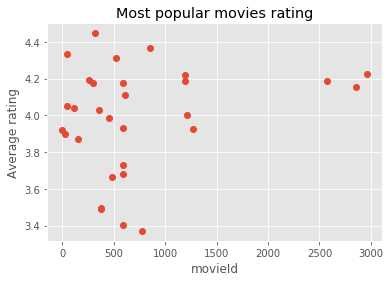

Best most popular movie ever is...Shawshank Redemption, The
Elapsed time(sec):  14.22


In [30]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

# Let's check those movies with +40k reviews, those should be pretty popular movies!
print(movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]]['title'])
# Let's check the average rating too, those should be pretty good movies!
ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most popular movies rating')
plt.show()

# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean()
best = movies.set_index('movieId').loc[tmp.rating.idxmax].title
print ('Best most popular movie ever is...%s' %best)

# Housekeeping
%reset_selective -f (^dftmp$|^tmp$|^best$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [34]:
runtime = default_timer() - start
print ("Elapsed time(sec): ", round(runtime,2))

# Housekeeping
%reset_selective -f (^runtime$|^st$|^start$)

Elapsed time(sec):  7.66


In [35]:
%whos

Variable        Type                          Data/Info
-------------------------------------------------------
default_timer   builtin_function_or_method    <built-in function perf_counter>
genres_unique   DataFrame                                      genre\n0<...>r\n19  (no genres listed)
movies          DataFrame                            movieId           <...>[27256 rows x 23 columns]
np              module                        <module 'numpy' from 'c:\<...>ges\\numpy\\__init__.py'>
pd              module                        <module 'pandas' from 'c:<...>es\\pandas\\__init__.py'>
plt             module                        <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
ratings         DataFrame                               userId  movieId<...>0000263 rows x 4 columns]
warnings        module                        <module 'warnings' from '<...>hon36\\lib\\warnings.py'>
